In [61]:
# =====================================================================
# Import
# =====================================================================

# Import internal modules
import os.path
from typing import List, Set, Dict, TypedDict, Tuple, Optional

# Import 3rd party modules
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [62]:
def get_sound_files(folder: str) -> pd.DataFrame:
    """
    Function to get all sound files within a folder.
    Param: `folder` name includes background noise level and machine type (e.g. -6_db_fan)    
    Return: a DataFrame  
    """
    # Create empty lists
    sound_list: List[str] = []  # will contain all sound filenames
    sound_path_list: List[str] = []  # will contain the sound's filepaths
    noise_db_list: List[int] = [] # will contain the background noise level in db of each sound
    machine_type_list: List[str] = [] # will contain the machine type of each sound
    model_id_list: List[str] = []  # will contain the machine product id of each sound
    target_list: List[str] = [] # will contain the target value (normal=0 or anormal=1) for each sound

    # Get the relative path of the directory that contains all the sound files
    folder_path = os.path.join("assets", "sounds", folder)

    # Get all the filenames within the directory
    for path, dirs, files in os.walk(folder_path):
        for filename in files:
            # Search only filenames with the extension ".wav"
            if filename.lower().endswith(".wav"):

                # Get the filename
                sound_list.append(filename)

                # Get the filepath
                sound_path = os.path.join(path, filename)
                sound_path_list.append(sound_path)
                
                # Split filepath to retrieve the information
                path_splitted = sound_path.split("/")
                
                # Get the background noise in db
                noise_db = int(path_splitted[2].split("_")[0])
                noise_db_list.append(noise_db)
                
                # Get the machine type
                machine_type = path_splitted[2].split("_")[2]
                machine_type_list.append(machine_type)
                
                # Get the model id
                model_id = path_splitted[3].split("_")[1]
                model_id_list.append(model_id)
                
                # Get target variable (normal or anormal)
                target = path_splitted[4]
                target_list.append(target)   
    
    # Create list with the data
    data: List[float, int, str] = list(zip(noise_db_list, machine_type_list, model_id_list, sound_list, sound_path_list, target_list))
    
    # Create list with column names
    cols: List[str] = ["noise_db", "machine_type", "model_id", "sound", "sound_path", "target"]
    
    # Return a DataFrame from the lists
    return pd.DataFrame(data=data, columns=cols)

def get_all_sounds(db_list: List[int], machine_type_list: List[str]) -> pd.DataFrame:
    """
    Function to get all sound files for specified lists of background noise and machine type.
    Param: * `db_list` is a list of background noise level (i.e. -6, 0, 6)
           * `machine_type_list` is a list of machine type (i.e. fan, pump, valve, slider) 
    Return: a DataFrame  
    """
    df_list = []
    for db in db_list:
        for machine_type in machine_type_list:
            df = get_sound_files(f"{db}_dB_{machine_type}")
            df_list.append(df)
            
    return pd.concat(df_list, axis=0)

In [205]:
def get_audio_features(sound_path: str) -> List[float]:
    """
    Function to extract audio features from the sound file
    Param: `sound_path` is the filepath of the sound
    Return: a list of audio features aggregated by their average values
    """
    # Read audio file
    y, sr = librosa.load(sound_path)

    # short-time Fourier Transform
    stft = librosa.stft(y)

    # Get spectogram
    spect: np.ndarray = np.abs(stft)
    spect_mean: np.float = np.mean(spect)
    spect_min: np.float = np.min(spect)
    spect_max: np.float = np.max(spect)
    spect_std: np.float = np.std(spect)
    
    # Get mel spectogram
    mel_spect: np.ndarray = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048)
    mel_spect_mean: np.float = np.mean(mel_spect)
    mel_spect_min: np.float = np.min(mel_spect)
    mel_spect_max: np.float = np.max(mel_spect)
    mel_spect_std: np.float = np.std(mel_spect)

    # Get chromagram
    chroma: np.ndarray = librosa.feature.chroma_stft(S=spect, sr=sr)
    chroma_mean: np.float = np.mean(chroma)
    chroma_min: np.float = np.min(chroma)
    chroma_max: np.float = np.max(chroma)
    chroma_std: np.float = np.std(chroma)

    # Get constant-Q chromagram
    chroma_cq: np.ndarray = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cq_mean: np.float = np.mean(chroma_cq)
    chroma_cq_min: np.float = np.min(chroma_cq)
    chroma_cq_max: np.float = np.max(chroma_cq)
    chroma_cq_std: np.float = np.std(chroma_cq)
    
    # Get chromagram cens
    chroma_cens: np.ndarray = librosa.feature.chroma_cens(y=y, sr=sr)
    chroma_cens_mean: np.float = np.mean(chroma_cens)
    chroma_cens_min: np.float = np.min(chroma_cens)
    chroma_cens_max: np.float = np.max(chroma_cens)
    chroma_cens_std: np.float = np.std(chroma_cens)

    # Get mfcc
    mfcc: np.ndarray = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_mean: np.float = np.mean(mfcc)
    mfcc_min: np.float = np.min(mfcc)
    mfcc_max: np.float = np.max(mfcc)
    mfcc_std: np.float = np.std(mfcc)

    # Get rms
    S: np.ndarray
    phase: np.ndarray
    S, phase = librosa.magphase(stft)
    rms: np.ndarray = librosa.feature.rms(S=S)
    rms_mean: np.float = np.mean(rms)
    rms_min: np.float = np.min(rms)
    rms_max: np.float = np.max(rms)
    rms_std: np.float = np.std(rms)
    
    # Get spectral centroid
    cent: np.ndarray = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_mean: np.float = np.mean(cent)
    cent_min: np.float = np.min(cent)
    cent_max: np.float = np.max(cent)
    cent_std: np.float = np.std(cent)
        
    # Get spectral bandwidth
    spec_bw: np.ndarray = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_bw_mean: np.float = np.mean(spec_bw)
    spec_bw_min: np.float = np.min(spec_bw)
    spec_bw_max: np.float = np.max(spec_bw)
    spec_bw_std: np.float = np.std(spec_bw)
        
    # Get spectral contrast
    contrast: np.ndarray = librosa.feature.spectral_contrast(S=S, sr=sr)
    contrast_mean: np.float = np.mean(contrast)
    contrast_min: np.float = np.min(contrast)
    contrast_max: np.float = np.max(contrast)
    contrast_std: np.float = np.std(contrast)

    # Get spectral flatness
    flatness: np.ndarray = librosa.feature.spectral_flatness(y=y)
    flatness_mean: np.float = np.mean(flatness)
    flatness_min: np.float = np.min(flatness)
    flatness_max: np.float = np.max(flatness)
    flatness_std: np.float = np.std(flatness)
    
    # Get roll-off frequency
    roll_off: np.ndarray = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
    roll_off_mean: np.float = np.mean(roll_off)
    roll_off_min: np.float = np.min(roll_off)
    roll_off_max: np.float = np.max(roll_off)
    roll_off_std: np.float = np.std(roll_off)

    # tonal centroid features (tonnetz)
    tonnetz: np.ndarray = librosa.feature.tonnetz(y=y, sr=sr)
    tonnetz_mean: np.float = np.mean(tonnetz)
    tonnetz_min: np.float = np.min(tonnetz)
    tonnetz_max: np.float = np.max(tonnetz)
    tonnetz_std: np.float = np.std(tonnetz)
        
    # zero-crossing rate
    zero_crossing_rate: np.ndarray = librosa.feature.zero_crossing_rate(y)
    zero_crossing_rate_mean: np.float = np.mean(zero_crossing_rate)
    zero_crossing_rate_min: np.float = np.min(zero_crossing_rate)
    zero_crossing_rate_max: np.float = np.max(zero_crossing_rate)
    zero_crossing_rate_std: np.float = np.std(zero_crossing_rate)
    
    # d_harmonic, d_percussive
    d_harmonic, d_percussive = librosa.decompose.hpss(stft)
    d_harmonic_abs = np.abs(d_harmonic)
    d_percussive_abs = np.abs(d_percussive)
    
    d_harmonic_mean: np.float = np.mean(d_harmonic_abs)
    d_harmonic_min: np.float = np.min(d_harmonic_abs)
    d_harmonic_max: np.float = np.max(d_harmonic_abs)    
    d_harmonic_std: np.float = np.std(d_harmonic_abs)
        
    d_percussive_mean: np.float = np.mean(d_percussive_abs)
    d_percussive_min: np.float = np.min(d_percussive_abs)
    d_percussive_max: np.float = np.max(d_percussive_abs)    
    d_percussive_std: np.float = np.std(d_percussive_abs)  
    
    
    # Return a list of audio features aggregated by their average values
    return [spect_mean, spect_min, spect_max, spect_std,
            mel_spect_mean, mel_spect_min, mel_spect_max, mel_spect_std,
            chroma_mean, chroma_min, chroma_max, chroma_std,
            chroma_cq_mean, chroma_cq_min, chroma_cq_max, chroma_cq_std,
            chroma_cens_mean, chroma_cens_min, chroma_cens_max, chroma_cens_std,
            mfcc_mean, mfcc_min, mfcc_max, mfcc_std,
            rms_mean, rms_min, rms_max, rms_std,
            cent_mean, cent_min, cent_max, cent_std,
            spec_bw_mean, spec_bw_min, spec_bw_max, spec_bw_std,
            contrast_mean, contrast_min, contrast_max, contrast_std,
            flatness_mean, flatness_min, flatness_max, flatness_std,
            roll_off_mean, roll_off_min, roll_off_max, roll_off_std,
            tonnetz_mean, tonnetz_min, tonnetz_max, tonnetz_std,
            zero_crossing_rate_mean, zero_crossing_rate_min, zero_crossing_rate_max, zero_crossing_rate_std,
            d_harmonic_mean, d_harmonic_min, d_harmonic_max, d_harmonic_std,
            d_percussive_mean, d_percussive_min, d_percussive_max, d_percussive_std
           ]

In [206]:
df_test = get_all_sounds([-6, 0, 6], ["fan", "valve", "pump", "slider"])
# df_test = get_all_sounds([-6], ["fan"])
df.head()

,noise_db,machine_type,model_id,sound,sound_path,target
0,-6,fan,00,00000059.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000005...,abnormal
1,-6,fan,00,00000071.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000007...,abnormal
2,-6,fan,00,00000065.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000006...,abnormal
3,-6,fan,00,00000273.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000027...,abnormal
4,-6,fan,00,00000267.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000026...,abnormal


In [161]:
df_test.shape

(54057, 6)

In [214]:
df_test_sample = df_test.sample(frac=0.05)

In [216]:
df_test_sample.shape

(2703, 6)

In [201]:
df_test_sample.head()

,noise_db,machine_type,model_id,sound,sound_path,target
1118,0,pump,00,00000685.wav,assets/sounds/0_dB_pump/id_00/normal/00000685.wav,normal
574,6,slider,00,00000855.wav,assets/sounds/6_dB_slider/id_00/normal/0000085...,normal
1456,-6,fan,06,00000271.wav,assets/sounds/-6_dB_fan/id_06/abnormal/0000027...,abnormal
550,-6,fan,00,00000842.wav,assets/sounds/-6_dB_fan/id_00/normal/00000842.wav,normal
1709,0,slider,06,00000160.wav,assets/sounds/0_dB_slider/id_06/normal/0000016...,normal


In [145]:
df_test.head()

,noise_db,machine_type,model_id,sound,sound_path,target
0,-6,fan,00,00000059.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000005...,abnormal
1,-6,fan,00,00000071.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000007...,abnormal
2,-6,fan,00,00000065.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000006...,abnormal
3,-6,fan,00,00000273.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000027...,abnormal
4,-6,fan,00,00000267.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000026...,abnormal


In [150]:
import time

In [217]:
# Create list with column names
start = time.time()
# Code
audio_features_cols: List[str] = ["spect_mean", "spect_min", "spect_max", "spect_std",
            "mel_spect_mean", "mel_spect_min", "mel_spect_max", "mel_spect_std",
            "chroma_mean", "chroma_min", "chroma_max", "chroma_std",
            "chroma_cq_mean", "chroma_cq_min", "chroma_cq_max", "chroma_cq_std",
            "chroma_cens_mean", "chroma_cens_min", "chroma_cens_max", "chroma_cens_std",
            "mfcc_mean", "mfcc_min", "mfcc_max", "mfcc_std",
            "rms_mean", "rms_min", "rms_max", "rms_std",
            "cent_mean", "cent_min", "cent_max", "cent_std",
            "spec_bw_mean", "spec_bw_min", "spec_bw_max", "spec_bw_std",
            "contrast_mean", "contrast_min", "contrast_max", "contrast_std",
            "flatness_mean", "flatness_min", "flatness_max", "flatness_std",
            "roll_off_mean", "roll_off_min", "roll_off_max", "roll_off_std",
            "tonnetz_mean", "tonnetz_min", "tonnetz_max", "tonnetz_std",
            "zero_crossing_rate_mean", "zero_crossing_rate_min", "zero_crossing_rate_max", "zero_crossing_rate_std",
            "d_harmonic_mean", "d_harmonic_min", "d_harmonic_max", "d_harmonic_std",
            "d_percussive_mean", "d_percussive_min", "d_percussive_max", "d_percussive_std"
           ]

df_test_sample[audio_features_cols] = df_test_sample[["sound_path"]].apply(lambda x: pd.Series(get_audio_features(x.sound_path)), axis=1)

end = time.time()
print(end - start)


4529.137727975845


In [218]:
4529.137727975845/60

75.48562879959742

In [219]:
df_test_sample.head()

,noise_db,machine_type,model_id,sound,sound_path,target,spect_mean,spect_min,spect_max,spect_std,...,zero_crossing_rate_max,zero_crossing_rate_std,d_harmonic_mean,d_harmonic_min,d_harmonic_max,d_harmonic_std,d_percussive_mean,d_percussive_min,d_percussive_max,d_percussive_std
1938,-6,slider,06,00000325.wav,assets/sounds/-6_dB_slider/id_06/normal/000003...,normal,0.086186,1.850374e-10,8.282417,0.239661,...,0.183105,0.019458,0.051047,3.093022e-13,8.259317,0.196500,0.035139,8.307444e-11,3.125634,0.079335
773,0,pump,00,00000814.wav,assets/sounds/0_dB_pump/id_00/normal/00000814.wav,normal,0.064292,9.486077e-11,4.943036,0.152599,...,0.103516,0.011921,0.033057,1.974081e-13,2.383167,0.098131,0.031234,3.159423e-11,2.559869,0.068802
1047,6,valve,00,00000928.wav,assets/sounds/6_dB_valve/id_00/normal/00000928...,normal,0.028409,6.772467e-11,1.246882,0.074859,...,0.242188,0.035117,0.012415,7.563213e-14,0.953090,0.039711,0.015994,4.018324e-11,1.243116,0.048474
2212,-6,pump,06,00000043.wav,assets/sounds/-6_dB_pump/id_06/normal/00000043...,normal,0.099990,1.298539e-10,4.971423,0.284035,...,0.073730,0.005807,0.055119,5.787144e-14,4.255203,0.183855,0.044872,4.671323e-11,2.199901,0.119220
3750,-6,pump,02,00000420.wav,assets/sounds/-6_dB_pump/id_02/normal/00000420...,normal,0.094911,6.309869e-11,4.607907,0.261325,...,0.075684,0.006278,0.052051,9.006482e-14,4.094114,0.171043,0.042860,4.865160e-11,2.621902,0.111749


In [221]:
df_test_sample.to_csv("test_sample_csv", index=False)

In [220]:
df_test_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2703 entries, 1938 to 2407
Data columns (total 70 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   noise_db                 2703 non-null   int64  
 1   machine_type             2703 non-null   object 
 2   model_id                 2703 non-null   object 
 3   sound                    2703 non-null   object 
 4   sound_path               2703 non-null   object 
 5   target                   2703 non-null   object 
 6   spect_mean               2703 non-null   float64
 7   spect_min                2703 non-null   float64
 8   spect_max                2703 non-null   float64
 9   spect_std                2703 non-null   float64
 10  mel_spect_mean           2703 non-null   float64
 11  mel_spect_min            2703 non-null   float64
 12  mel_spect_max            2703 non-null   float64
 13  mel_spect_std            2703 non-null   float64
 14  chroma_mean          

In [223]:
# Correlation matrix
df_test_sample.corr().style.background_gradient(cmap="coolwarm")

,noise_db,spect_mean,spect_min,spect_max,spect_std,mel_spect_mean,mel_spect_min,mel_spect_max,mel_spect_std,chroma_mean,chroma_min,chroma_max,chroma_std,chroma_cq_mean,chroma_cq_min,chroma_cq_max,chroma_cq_std,chroma_cens_mean,chroma_cens_min,chroma_cens_max,chroma_cens_std,mfcc_mean,mfcc_min,mfcc_max,mfcc_std,rms_mean,rms_min,rms_max,rms_std,cent_mean,cent_min,cent_max,cent_std,spec_bw_mean,spec_bw_min,spec_bw_max,spec_bw_std,contrast_mean,contrast_min,contrast_max,contrast_std,flatness_mean,flatness_min,flatness_max,flatness_std,roll_off_mean,roll_off_min,roll_off_max,roll_off_std,tonnetz_mean,tonnetz_min,tonnetz_max,tonnetz_std,zero_crossing_rate_mean,zero_crossing_rate_min,zero_crossing_rate_max,zero_crossing_rate_std,d_harmonic_mean,d_harmonic_min,d_harmonic_max,d_harmonic_std,d_percussive_mean,d_percussive_min,d_percussive_max,d_percussive_std
noise_db,1.000000,-0.826531,-0.385662,-0.595633,-0.843149,-0.804999,-0.815046,-0.373454,-0.636112,-0.088140,-0.185506,nan,0.154630,-0.140576,-0.147787,nan,0.152998,-0.190212,-0.066770,0.176501,0.167425,-0.717420,-0.730464,-0.098756,0.730750,-0.859267,-0.835556,-0.637994,-0.323286,0.130115,0.050637,0.124257,0.146231,0.078497,-0.009578,0.060483,0.058742,0.115925,0.067986,0.054470,0.017497,0.328997,0.245976,0.074498,0.123663,0.061003,-0.009569,0.050333,0.043991,0.034015,-0.095387,0.137477,0.184944,0.097057,0.047503,0.163867,0.179946,-0.827612,-0.316307,-0.602881,-0.740777,-0.770131,-0.409554,-0.341624,-0.776405
spect_mean,-0.826531,1.000000,0.388537,0.568976,0.844726,0.835251,0.855097,0.431885,0.639501,0.170933,0.290127,nan,-0.269600,0.195100,0.248424,nan,-0.277037,0.226854,0.254469,-0.204748,-0.246634,0.639941,0.880593,-0.066748,-0.924649,0.879659,0.863245,0.636277,0.348164,0.143895,0.218444,-0.168429,-0.251070,0.085393,0.183498,-0.141960,-0.187666,-0.121776,-0.113565,-0.092359,0.184599,-0.094307,-0.000401,0.100159,0.048344,0.109950,0.187355,-0.104625,-0.181816,-0.045657,0.128960,-0.187312,-0.226600,0.179706,0.217199,-0.119373,-0.207396,0.976422,0.315024,0.538301,0.707231,0.962881,0.412436,0.370811,0.825582
spect_min,-0.385662,0.388537,1.000000,0.305960,0.430358,0.419539,0.419899,0.219592,0.361992,0.011076,0.075876,nan,-0.053129,-0.032675,-0.009201,nan,0.006569,-0.014947,0.005097,-0.010296,0.019710,0.335810,0.345037,0.054164,-0.333589,0.435003,0.423150,0.291853,0.152133,-0.095637,-0.029924,-0.141212,-0.141643,-0.089863,-0.021597,-0.093572,-0.073471,-0.030279,0.023532,-0.103583,-0.083619,-0.199179,-0.112809,-0.083453,-0.121499,-0.081520,-0.027261,-0.103031,-0.053988,-0.051122,-0.023867,-0.045371,-0.005830,-0.083847,-0.037235,-0.166018,-0.167217,0.399679,0.176444,0.314168,0.397665,0.348727,0.904051,0.159211,0.355489
spect_max,-0.595633,0.568976,0.305960,1.000000,0.766913,0.770216,0.576523,0.868683,0.900965,-0.037516,-0.057790,nan,0.037963,-0.150689,-0.226047,nan,0.186283,-0.117319,-0.151121,0.165921,0.122164,0.526388,0.426643,0.043765,-0.509703,0.732027,0.566987,0.844784,0.729880,-0.214090,-0.230837,-0.194872,-0.113940,-0.116384,-0.135616,-0.081013,-0.014206,-0.012084,0.004704,-0.157731,-0.172021,-0.385536,-0.419796,-0.174439,-0.216130,-0.119842,-0.138703,-0.091584,0.016909,0.107920,-0.104992,0.192581,0.149947,-0.250690,-0.242616,-0.240859,-0.158772,0.592509,0.235196,0.928494,0.744587,0.501655,0.302732,0.627319,0.616694
spect_std,-0.843149,0.844726,0.430358,0.766913,1.000000,0.984429,0.909690,0.548727,0.890382,-0.001090,0.132627,nan,-0.083345,-0.098179,-0.049183,nan,0.025699,-0.069178,-0.035191,0.035079,0.066324,0.720291,0.706096,0.162602,-0.708956,0.995758,0.918494,0.726836,0.457111,-0.274763,-0.168060,-0.345948,-0.283912,-0.228187,-0.110147,-0.244361,-0.155805,-0.059893,0.059455,-0.294447,-0.242846,-0.498283,-0.369503,-0.198401,-0.270377,-0.211408,-0.114125,-0.246195,-0.108702,-0.016351,-0.034082,-0.010826,0.045910,-0.263599,-0.181941,-0.377141,-0.319335,0.877243,0.327875,0.776357,0.937443,0.747807,0.450208,0.423066,0.810415
mel_spect_mean,-0.804999,0.835251,0.419539,0.770216,0.98442

In [224]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [225]:
# Select data
## select numeric columns
cols = df_test_sample.select_dtypes(include="number").columns.tolist()

## drop noise_db and model_id columns
# cols.remove("noise_db")
# cols.remove("model_id")

# select features and target
X = df_test_sample[cols]
y = df_test_sample.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Create classifier and fit it to the training set
# random_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=5, criterion = 'entropy')
random_classifier = RandomForestClassifier(n_estimators=100, random_state=5, criterion = 'entropy')
random_classifier.fit(X_train, y_train)

# Compute model score
random_classifier.score(X_test, y_test)

# Compute model score
print("model score: ", random_classifier.score(X_test, y_test))

# Evaluate model
print(classification_report(y_test, random_classifier.predict(X_test)))

model score:  0.8909426987060998
              precision    recall  f1-score   support

    abnormal       0.98      0.46      0.63       108
      normal       0.88      1.00      0.94       433

    accuracy                           0.89       541
   macro avg       0.93      0.73      0.78       541
weighted avg       0.90      0.89      0.87       541



'spect_mean'

Feature ranking:
1. feature 28 (0.039742) rms_std
2. feature 27 (0.032174) rms_max
3. feature 63 (0.026810) d_percussive_max
4. feature 64 (0.026075) d_percussive_std
5. feature 10 (0.023674) chroma_min
6. feature 8 (0.023619) mel_spect_std
7. feature 25 (0.022769) rms_mean
8. feature 32 (0.022535) cent_std
9. feature 49 (0.021389) tonnetz_mean
10. feature 4 (0.020913) spect_std
11. feature 60 (0.020823) d_harmonic_std
12. feature 56 (0.020312) zero_crossing_rate_std
13. feature 5 (0.019753) mel_spect_mean
14. feature 1 (0.019581) spect_mean
15. feature 21 (0.019360) mfcc_mean
16. feature 36 (0.019294) spec_bw_std
17. feature 61 (0.019280) d_percussive_mean
18. feature 52 (0.018945) tonnetz_std
19. feature 47 (0.017870) roll_off_max
20. feature 12 (0.017806) chroma_std
21. feature 51 (0.017557) tonnetz_max
22. feature 31 (0.017550) cent_max
23. feature 57 (0.017328) d_harmonic_mean
24. feature 13 (0.016616) chroma_cq_mean
25. feature 59 (0.016595) d_harmonic_max
26. feature 19 (0.01655

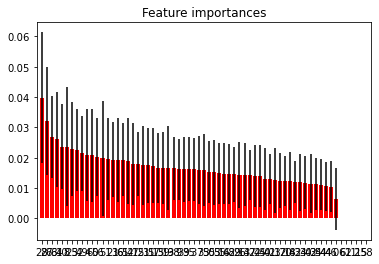

In [240]:
importances = random_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

importance_ranking = []
features_id = []
features = []
importance = []

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), X_train.columns[indices[f]])
    importance_ranking.append(f+1)
    importance.append(importances[indices[f]])
    features_id.append(indices[f])
    features.append(X_train.columns[indices[f]])

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [242]:
importance_data = list(zip(importance_ranking, features_id, features, importance))
importance_cols = "importance_ranking", "features_id", "features", "importance"
importance_df = pd.DataFrame(data=importance_data, columns=importance_cols)

In [243]:
importance_df

,importance_ranking,features_id,features,importance
0,1,28,rms_std,0.039742
1,2,27,rms_max,0.032174
2,3,63,d_percussive_max,0.026810
3,4,64,d_percussive_std,0.026075
4,5,10,chroma_min,0.023674
...,...,...,...,...
60,61,62,d_percussive_min,0.000000
61,62,11,chroma_max,0.000000
62,63,2,spect_min,0.000000
63,64,15,chroma_cq_max,0.000000


In [294]:
df_test_sample_corr = df_test_sample.corr()

for ranking, f in enumerate(importance_df.features.values, start=1):
    print("############ ", ranking, f, " ############")
    print(df_test_sample_corr.loc[f, (df_test_sample_corr[f] > 0.85) | (df_test_sample_corr[f] < -0.85)])

############  1 rms_std  ############
rms_std    1.0
Name: rms_std, dtype: float64
############  2 rms_max  ############
rms_max    1.0
Name: rms_max, dtype: float64
############  3 d_percussive_max  ############
d_percussive_max    1.0
Name: d_percussive_max, dtype: float64
############  4 d_percussive_std  ############
d_percussive_mean    0.881866
d_percussive_std     1.000000
Name: d_percussive_std, dtype: float64
############  5 chroma_min  ############
chroma_min    1.000000
chroma_std   -0.917558
Name: chroma_min, dtype: float64
############  6 mel_spect_std  ############
spect_max         0.900965
spect_std         0.890382
mel_spect_mean    0.908583
mel_spect_std     1.000000
rms_mean          0.858361
d_harmonic_max    0.882052
d_harmonic_std    0.877802
Name: mel_spect_std, dtype: float64
############  7 rms_mean  ############
noise_db          -0.859267
spect_mean         0.879659
spect_std          0.995758
mel_spect_mean     0.977798
mel_spect_min      0.927889
mel_spect_

In [292]:
for f in importance_df.features.values:
    print(f)

rms_std
rms_max
d_percussive_max
d_percussive_std
chroma_min
mel_spect_std
rms_mean
cent_std
tonnetz_mean
spect_std
d_harmonic_std
zero_crossing_rate_std
mel_spect_mean
spect_mean
mfcc_mean
spec_bw_std
d_percussive_mean
tonnetz_std
roll_off_max
chroma_std
tonnetz_max
cent_max
d_harmonic_mean
chroma_cq_mean
d_harmonic_max
chroma_cens_max
contrast_min
chroma_mean
contrast_max
spec_bw_max
spect_max
mel_spect_max
spec_bw_mean
tonnetz_min
zero_crossing_rate_mean
zero_crossing_rate_max
chroma_cq_std
roll_off_std
cent_mean
rms_min
chroma_cq_min
contrast_mean
mfcc_min
roll_off_mean
contrast_std
flatness_mean
mfcc_max
chroma_cens_mean
chroma_cens_std
chroma_cens_min
flatness_max
mfcc_std
cent_min
flatness_min
spec_bw_min
zero_crossing_rate_min
flatness_std
roll_off_min
noise_db
mel_spect_min
d_percussive_min
chroma_max
spect_min
chroma_cq_max
d_harmonic_min


In [280]:
abs(-0.80)

0.8

In [236]:
df_test_sample.machine_type.value_counts()

fan       837
pump      660
slider    616
valve     590
Name: machine_type, dtype: int64

In [73]:
# Create list with column names
audio_features_cols: List[str] = ["spectogram", "mel_spectogram",
                   "chromagram", "chromagram_cq", "chromagram_cens",
                   "mfcc", "rms", "spectral_centroid", 
                   "spectral_bandwidth", "spectral_contrast", "spectral_flatness",
                   "roll_off_frequency", "tonnetz", "zero_crossing_rate"]

# Create empty columns
for col in audio_features_cols:
    df_test[col] = np.nan

for idx, sound in enumerate(df_test.sound_path.values):
    feature_values_list = get_audio_features(sound)
#     print(feature_values_list)
    for i in range(len(feature_values_list)):
#         print(idx, str(audio_features_cols[i]), feature_values_list[i])
        df_test[audio_features_cols[i]].iloc[idx] = feature_values_list[i]

<ipython-input-73-3ddbd839b8d8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = np.nan
/Users/derrickvanfrausum/anaconda3/envs/mimii/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/derrickvanfrausum/anaconda3/envs/mimii/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
# Create list with column names
audio_features_cols: List[str] = ["spectogram", "mel_spectogram",
                   "chromagram", "chromagram_cq", "chromagram_cens",
                   "mfcc", "rms", "spectral_centroid", 
                   "spectral_bandwidth", "spectral_contrast", "spectral_flatness",
                   "roll_off_frequency", "tonnetz", "zero_crossing_rate"]

# Create empty columns
for col in audio_features_cols:
    df_test[col] = np.nan

for idx, sound in enumerate(df_test.sound_path.values):
    feature_values_list = get_audio_features(sound)
#     print(feature_values_list)
    for i in range(len(feature_values_list)):
#         print(idx, str(audio_features_cols[i]), feature_values_list[i])
        df_test[audio_features_cols[i]].iloc[idx] = feature_values_list[i]

In [78]:
# Create list with column names
audio_features_cols: List[str] = ["spectogram", "mel_spectogram",
                   "chromagram", "chromagram_cq", "chromagram_cens",
                   "mfcc", "rms", "spectral_centroid", 
                   "spectral_bandwidth", "spectral_contrast", "spectral_flatness",
                   "roll_off_frequency", "tonnetz", "zero_crossing_rate"]

# Create empty columns
for col in audio_features_cols:
    df_test[col] = np.nan
df_test.head()

<ipython-input-78-d9b23d7bb279>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = np.nan


,noise_db,machine_type,model_id,sound,sound_path,target,spectogram,mel_spectogram,chromagram,chromagram_cq,chromagram_cens,mfcc,rms,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,roll_off_frequency,tonnetz,zero_crossing_rate
0,-6,fan,00,00000059.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000005...,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-6,fan,00,00000071.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000007...,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-6,fan,00,00000065.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000006...,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-6,fan,00,00000273.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000027...,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-6,fan,00,00000267.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000026...,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
audio_features_list_all_sounds.append(df_test.sound_path.values)

In [92]:
audio_features_list_all_sounds = []
for sound_path in df_test.sound_path.values:
    audio_features_list = get_audio_features(sound_path)
    audio_features_list.append(sound_path)
    audio_features_list_all_sounds.append(audio_features_list)
audio_features_list_all_sounds

[[0.08797987,
  0.03412381,
  0.51950985,
  0.3487876,
  0.24360700893714782,
  -4.0447407,
  0.007393384808553433,
  1180.264030852038,
  1579.0006992822268,
  24.305225494964127,
  0.00013324826,
  5154.828999601218,
  0.04250314218185303,
  0.049592834614269145,
  'assets/sounds/-6_dB_fan/id_00/abnormal/00000059.wav'],
 [0.100927845,
  0.039812844,
  0.75366986,
  0.38985088,
  0.2539249235509849,
  -3.4927447,
  0.007938459534366313,
  1036.5130803953173,
  1375.484191023654,
  21.28200050194736,
  0.00011218998,
  4208.891873459252,
  0.050503582874733076,
  0.03764976979408353,
  'assets/sounds/-6_dB_fan/id_00/abnormal/00000071.wav'],
 [0.08988863,
  0.03654531,
  0.53370386,
  0.35151482,
  0.24256478440084428,
  -3.9055371,
  0.007584500401487915,
  1271.4472060240762,
  1735.2508219906167,
  24.272329736071338,
  0.00014936722,
  5743.070144830336,
  0.0437188022909946,
  0.04943649398201856,
  'assets/sounds/-6_dB_fan/id_00/abnormal/00000065.wav'],
 [0.0902425,
  0.025801158,

In [123]:
audio_features_list_all_sounds = []
for sound_path in df_test.sound_path.values:
    audio_features_list = get_audio_features(sound_path)
#     audio_features_list.append(sound_path)
    audio_features_list_all_sounds.append(audio_features_list)

# Create list with column names
audio_features_cols: List[str] = ["spectogram", "mel_spectogram",
                   "chromagram", "chromagram_cq", "chromagram_cens",
                   "mfcc", "rms", "spectral_centroid", 
                   "spectral_bandwidth", "spectral_contrast", "spectral_flatness",
                   "roll_off_frequency", "tonnetz", "zero_crossing_rate"]
df_audio_features = pd.DataFrame(data=audio_features_list_all_sounds,columns=audio_features_cols)

df_all = pd.concat([df_test, df_audio_features], axis=1)

In [124]:
df_all.head()

,noise_db,machine_type,model_id,sound,sound_path,target,spectogram,mel_spectogram,chromagram,chromagram_cq,chromagram_cens,mfcc,rms,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,roll_off_frequency,tonnetz,zero_crossing_rate
0,-6,fan,00,00000059.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000005...,abnormal,0.087980,0.034124,0.519510,0.348788,0.243607,-4.044741,0.007393,1180.264031,1579.000699,24.305225,0.000133,5154.829000,0.042503,0.049593
1,-6,fan,00,00000071.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000007...,abnormal,0.100928,0.039813,0.753670,0.389851,0.253925,-3.492745,0.007938,1036.513080,1375.484191,21.282001,0.000112,4208.891873,0.050504,0.037650
2,-6,fan,00,00000065.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000006...,abnormal,0.089889,0.036545,0.533704,0.351515,0.242565,-3.905537,0.007585,1271.447206,1735.250822,24.272330,0.000149,5743.070145,0.043719,0.049436
3,-6,fan,00,00000273.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000027...,abnormal,0.090242,0.025801,0.730573,0.508074,0.269959,-3.973263,0.006392,1050.479779,1347.219254,21.138120,0.000141,4106.271922,-0.022377,0.044327
4,-6,fan,00,00000267.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000026...,abnormal,0.087292,0.022661,0.583526,0.484912,0.270946,-4.673796,0.005993,1414.325444,1763.148493,23.825591,0.000246,5714.992047,-0.038684,0.066287


In [125]:
df_all.shape

(5550, 20)

In [95]:
df_audio_features.sound_path[1]

'assets/sounds/-6_dB_fan/id_00/abnormal/00000071.wav'

In [110]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   noise_db      5 non-null      int64 
 1   machine_type  5 non-null      object
 2   model_id      5 non-null      object
 3   sound         5 non-null      object
 4   sound_path    5 non-null      object
 5   target        5 non-null      object
dtypes: int64(1), object(5)
memory usage: 368.0+ bytes


In [109]:
df_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   spectogram          5 non-null      float64
 1   mel_spectogram      5 non-null      float64
 2   chromagram          5 non-null      float64
 3   chromagram_cq       5 non-null      float64
 4   chromagram_cens     5 non-null      float64
 5   mfcc                5 non-null      float64
 6   rms                 5 non-null      float64
 7   spectral_centroid   5 non-null      float64
 8   spectral_bandwidth  5 non-null      float64
 9   spectral_contrast   5 non-null      float64
 10  spectral_flatness   5 non-null      float64
 11  roll_off_frequency  5 non-null      float64
 12  tonnetz             5 non-null      float64
 13  zero_crossing_rate  5 non-null      float64
 14  sound_path          5 non-null      object 
dtypes: float64(14), object(1)
memory usage: 728.0+ bytes


In [115]:
df_all = pd.concat([df_test, df_audio_features], axis=1)

In [116]:
df_all

,noise_db,machine_type,model_id,sound,sound_path,target,spectogram,mel_spectogram,chromagram,chromagram_cq,...,mfcc,rms,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,roll_off_frequency,tonnetz,zero_crossing_rate,sound_path
0,-6,fan,00,00000059.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000005...,abnormal,0.087980,0.034124,0.519510,0.348788,...,-4.044741,0.007393,1180.264031,1579.000699,24.305225,0.000133,5154.829000,0.042503,0.049593,assets/sounds/-6_dB_fan/id_00/abnormal/0000005...
1,-6,fan,00,00000071.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000007...,abnormal,0.100928,0.039813,0.753670,0.389851,...,-3.492745,0.007938,1036.513080,1375.484191,21.282001,0.000112,4208.891873,0.050504,0.037650,assets/sounds/-6_dB_fan/id_00/abnormal/0000007...
2,-6,fan,00,00000065.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000006...,abnormal,0.089889,0.036545,0.533704,0.351515,...,-3.905537,0.007585,1271.447206,1735.250822,24.272330,0.000149,5743.070145,0.043719,0.049436,assets/sounds/-6_dB_fan/id_00/abnormal/0000006...
3,-6,fan,00,00000273.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000027...,abnormal,0.090242,0.025801,0.730573,0.508074,...,-3.973263,0.006392,1050.479779,1347.219254,21.138120,0.000141,4106.271922,-0.022377,0.044327,assets/sounds/-6_dB_fan/id_00/abnormal/0000027...
4,-6,fan,00,00000267.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000026...,abnormal,0.087292,0.022661,0.583526,0.484912,...,-4.673796,0.005993,1414.325444,1763.148493,23.825591,0.000246,5714.992047,-0.038684,0.066287,assets/sounds/-6_dB_fan/id_00/abnormal/0000026...


In [96]:
get_audio_features("assets/sounds/-6_dB_fan/id_00/abnormal/00000071.wav")

[0.100927845,
 0.039812844,
 0.75366986,
 0.38985088,
 0.2539249235509849,
 -3.4927447,
 0.007938459534366313,
 1036.5130803953173,
 1375.484191023654,
 21.28200050194736,
 0.00011218998,
 4208.891873459252,
 0.050503582874733076,
 0.03764976979408353]

In [74]:
df_test.head()

,noise_db,machine_type,model_id,sound,sound_path,target,spectogram,mel_spectogram,chromagram,chromagram_cq,chromagram_cens,mfcc,rms,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,roll_off_frequency,tonnetz,zero_crossing_rate
0,-6,fan,00,00000059.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000005...,abnormal,0.087980,0.034124,0.519510,0.348788,0.243607,-4.044741,0.007393,1180.264031,1579.000699,24.305225,0.000133,5154.829000,0.042503,0.049593
1,-6,fan,00,00000071.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000007...,abnormal,0.100928,0.039813,0.753670,0.389851,0.253925,-3.492745,0.007938,1036.513080,1375.484191,21.282001,0.000112,4208.891873,0.050504,0.037650
2,-6,fan,00,00000065.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000006...,abnormal,0.089889,0.036545,0.533704,0.351515,0.242565,-3.905537,0.007585,1271.447206,1735.250822,24.272330,0.000149,5743.070145,0.043719,0.049436
3,-6,fan,00,00000273.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000027...,abnormal,0.090242,0.025801,0.730573,0.508074,0.269959,-3.973263,0.006392,1050.479779,1347.219254,21.138120,0.000141,4106.271922,-0.022377,0.044327
4,-6,fan,00,00000267.wav,assets/sounds/-6_dB_fan/id_00/abnormal/0000026...,abnormal,0.087292,0.022661,0.583526,0.484912,0.270946,-4.673796,0.005993,1414.325444,1763.148493,23.825591,0.000246,5714.992047,-0.038684,0.066287


In [39]:
get_audio_features(df_test.sound_path.iloc[2])

[0.08988863,
 0.03654531,
 0.53370386,
 0.35151482,
 0.24256478440084428,
 -3.9055371,
 0.007584500401487915,
 1271.4472060240762,
 1735.2508219906167,
 24.272329736071338,
 0.00014936722,
 5743.070144830336,
 0.0437188022909946,
 0.04943649398201856]

In [9]:
df.head()

,noise_db,machine_type,model_id,sound,sound_path,target,spectogram,mel_spectogram,chromagram,chromagram_cq,chromagram_cens,mfcc,rms,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,roll_off_frequency,tonnetz,zero_crossing_rate
0,-6,slider,00,00000059.wav,assets/sounds/-6_db_slider/id_00/abnormal/0000...,abnormal,0.103656,0.028626,0.508862,0.514267,0.264862,-5.768414,0.006748,1746.776097,1955.708303,24.889785,0.000356,6312.725788,-0.014067,0.077769
1,-6,slider,00,00000071.wav,assets/sounds/-6_db_slider/id_00/abnormal/0000...,abnormal,0.102113,0.025405,0.592927,0.509345,0.265619,-5.547102,0.006390,1762.671976,1924.965304,24.371674,0.000404,6249.724931,-0.026640,0.080915
2,-6,slider,00,00000065.wav,assets/sounds/-6_db_slider/id_00/abnormal/0000...,abnormal,0.103404,0.029101,0.615363,0.519190,0.264350,-5.850099,0.006801,1797.617686,2018.689316,23.995691,0.000357,6408.051429,-0.015122,0.074452
3,-6,slider,00,00000273.wav,assets/sounds/-6_db_slider/id_00/abnormal/0000...,abnormal,0.120839,0.029576,0.674066,0.608943,0.279228,-4.685860,0.006914,1693.404780,1843.512061,21.976415,0.000446,5747.141969,-0.006995,0.082713
4,-6,slider,00,00000267.wav,assets/sounds/-6_db_slider/id_00/abnormal/0000...,abnormal,0.114762,0.032621,0.658467,0.624440,0.276571,-4.298293,0.007232,1503.216934,1768.753095,21.985056,0.000396,5490.966797,-0.000406,0.065476


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   noise_db            100 non-null    int64  
 1   machine_type        100 non-null    object 
 2   model_id            100 non-null    object 
 3   sound               100 non-null    object 
 4   sound_path          100 non-null    object 
 5   target              100 non-null    object 
 6   spectogram          100 non-null    float64
 7   mel_spectogram      100 non-null    float64
 8   chromagram          100 non-null    float64
 9   chromagram_cq       100 non-null    float64
 10  chromagram_cens     100 non-null    float64
 11  mfcc                100 non-null    float64
 12  rms                 100 non-null    float64
 13  spectral_centroid   100 non-null    float64
 14  spectral_bandwidth  100 non-null    float64
 15  spectral_contrast   100 non-null    float64
 16  spectral_

In [11]:
df.isnull().any()

noise_db              False
machine_type          False
model_id              False
sound                 False
sound_path            False
target                False
spectogram            False
mel_spectogram        False
chromagram            False
chromagram_cq         False
chromagram_cens       False
mfcc                  False
rms                   False
spectral_centroid     False
spectral_bandwidth    False
spectral_contrast     False
spectral_flatness     False
roll_off_frequency    False
tonnetz               False
zero_crossing_rate    False
dtype: bool

In [ ]:
# Get the relative path of the directory that contains all the sound files
folder_path = os.path.join("assets", "sounds", "6_dB_test")
sound_path_list = []

# Get all the filenames within the directory
for path, dirs, files in os.walk(folder_path):
    for filename in files:
        # Search only filenames with the extension ".wav"
        if filename.lower().endswith(".wav"):

            # Get the filename
            sound_list.append(filename)

            # Get the filepath
            sound_path = os.path.join(path, filename)
            sound_path_list.append(sound_path)

            # Split filepath to retrieve the information
            path_splitted = sound_path.split("/")

            # Get the background noise in db
            noise_db = int(path_splitted[2].split("_")[0])
            noise_db_list.append(noise_db)

            # Get the machine type
            machine_type = path_splitted[2].split("_")[2]
            machine_type_list.append(machine_type)

            # Get the model id
            model_id = path_splitted[3].split("_")[1]
            model_id_list.append(model_id)

            # Get target variable (normal aor anormal)
            target = path_splitted[4]
            target_list.append(target)
print()

In [126]:
df_all.to_csv("-6_dB_fan_csv", index=False)

In [128]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
noise_db,5550.0,-6.000000,0.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000
spectogram,5550.0,0.095662,0.012191,0.051801,0.087735,0.095607,0.103148,0.135741
mel_spectogram,5550.0,0.023828,0.005022,0.006050,0.021274,0.024094,0.025627,0.054556
chromagram,5550.0,0.696104,0.117973,0.366680,0.591525,0.741141,0.806373,0.881168
chromagram_cq,5550.0,0.596425,0.081941,0.221833,0.546890,0.606830,0.654831,0.777581
chromagram_cens,5550.0,0.273416,0.007121,0.189166,0.271032,0.274820,0.277670,0.286754
mfcc,5550.0,-4.778437,0.882483,-8.020124,-5.553728,-4.409894,-4.136958,-2.680073
rms,5550.0,0.006165,0.000584,0.003287,0.005858,0.006197,0.006413,0.009236
spectral_centroid,5550.0,1348.625165,295.305422,614.600016,1133.415694,1334.580598,1489.537732,2938.424171
spectral_bandwidth,5550.0,1577.985970,185.431110,1036.590126,1424.885814,1589.900545,1710.724472,2323.834034


In [129]:
df_all.isnull().any()

noise_db              False
machine_type          False
model_id              False
sound                 False
sound_path            False
target                False
spectogram            False
mel_spectogram        False
chromagram            False
chromagram_cq         False
chromagram_cens       False
mfcc                  False
rms                   False
spectral_centroid     False
spectral_bandwidth    False
spectral_contrast     False
spectral_flatness     False
roll_off_frequency    False
tonnetz               False
zero_crossing_rate    False
dtype: bool

In [133]:
df_all.iloc[100]

noise_db                                                             -6
machine_type                                                        fan
model_id                                                             00
sound                                                      00000198.wav
sound_path            assets/sounds/-6_dB_fan/id_00/abnormal/0000019...
target                                                         abnormal
spectogram                                                     0.089376
mel_spectogram                                                 0.021159
chromagram                                                     0.791502
chromagram_cq                                                  0.468329
chromagram_cens                                                0.264135
mfcc                                                             -4.083
rms                                                            0.005409
spectral_centroid                                           1360